In [25]:
colour_gradient_map = {
    "red": [
        "#fee6ce", "#fdae61", "#f46d43", "#d73027", "#a50026"
    ],
    "pink": [
        "#fde0dd", "#fa9fb5", "#f768a1", "#dd3497", "#7a0177"
    ],
    "purple": [
        "#f2f0f7", "#cbc9e2", "#9e9ac8", "#756bb1", "#54278f"
    ],
    "blue": [
        "#b3cde3", "#6497b1", "#005b96", "#03396c", "#011f4b"
    ],
    "green": [
        "#c7e9b4", "#7fc97f", "#4d8f4c", "#2b6138", "#00441b"
    ],
    "yellow": [
        "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c"
    ]
}

In [26]:
def get_graph_weights_colours(graph_path, idx):    
    # Load the graph and normalize weights
    G = nx.read_gexf(graph_path)

    # Extract original weights and normalize them
    weights = [data["weight"] for _, data in G.nodes(data=True)]
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform([[w] for w in weights]).flatten()

    # Assign normalized weights back to the graph
    for i, (node, data) in enumerate(G.nodes(data=True)):
        data["normalized_weight"] = normalized_weights[i]

    # Extract node information for word cloud
    hashtag_weights = {node: data["weight"] for node, data in G.nodes(data=True)}
    normalized_weights_dict = {node: data["normalized_weight"] for node, data in G.nodes(data=True)}

    # Define a color map for the word cloud
    colour = list(colour_gradient_map.keys())[idx]
    colour_map = mcolors.LinearSegmentedColormap.from_list(colour+"_gradient", colour_gradient_map[colour])

    return hashtag_weights, normalized_weights_dict, weights, colour_map

def color_func(word, colour_map, font_size, position, orientation, random_state=None, normalized_weight=None, **kwargs): 
    # Reverse the normalized weight for the color gradient
    normalized_weight = 1 - normalized_weight  # Reverse the gradient 

    # Map the normalized weight to a color using the colormap
    rgba_colour = colour_map(normalized_weight)
    
    # Convert RGBA to RGB tuple scaled to 0-255 and return as PIL-compatible color
    rgb_colour = tuple(int(255 * c) for c in rgba_colour[:3])
    return rgb_colour

def create_wordcloud(hashtag_weights, normalized_weights, weights, colour_map, idx):
    """
    Create a word cloud with colors based on normalized weights.

    Args:
        hashtag_weights: Dictionary of hashtags and their frequency.
        normalized_weights: Dictionary of normalized weights (keyed by word).
        color_map: A colormap for the gradient.
        idx: Index used to determine color flow.
    """
    # Generate the WordCloud with original weights for size and reversed normalized weights for color
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        color_func=lambda word, font_size, position, orientation, random_state=None, **kwargs: color_func(word, colour_map, font_size, position, orientation, random_state, normalized_weights.get(word, 0), **kwargs),
        max_words=200
    ).generate_from_frequencies(hashtag_weights)
    
    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Hashtag Word Cloud for Week {idx+1} with Colour Gradient by Node Weight (i.e. frequency)")

    # Create a color bar as the legend
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    sm = plt.cm.ScalarMappable(cmap=colour_map.reversed(), norm=norm)  # Reverse color bar to match the reversed gradient
    sm.set_array([])

    # Add color bar with original weight mapping
    cbar = plt.colorbar(sm, orientation="horizontal", fraction=0.046, pad=0.04)
    cbar.set_label("Frequency of use of Hashtag by colour")
    plt.savefig(f'wordClouds/word_cloud_{idx+1}.png', dpi=300)
    plt.show()


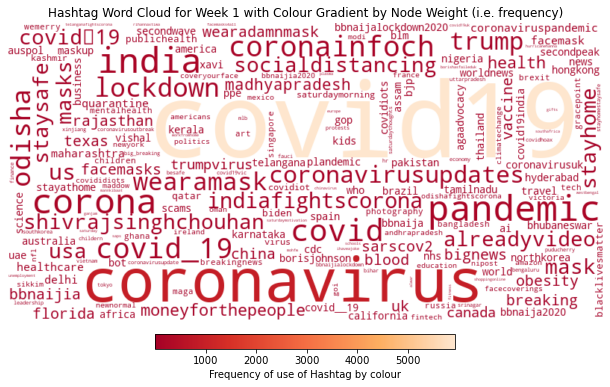

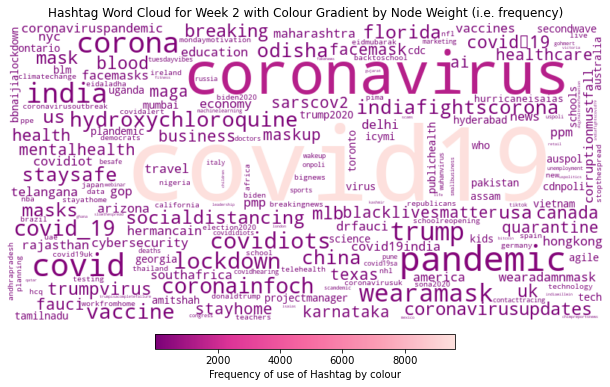

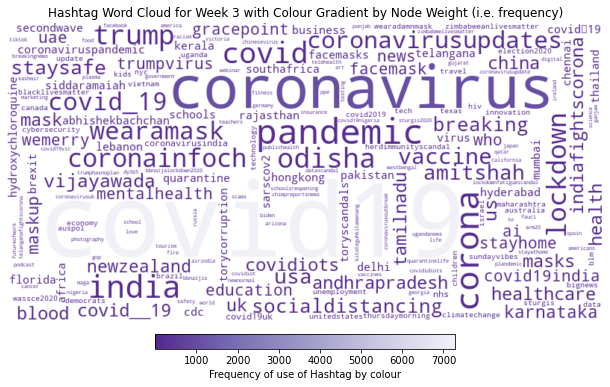

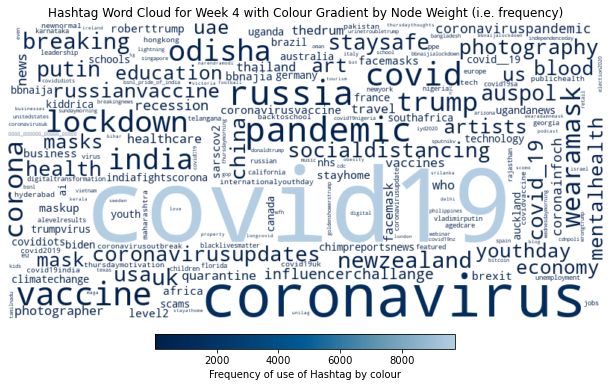

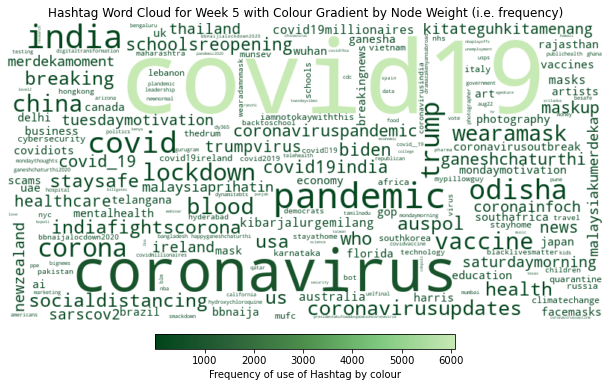

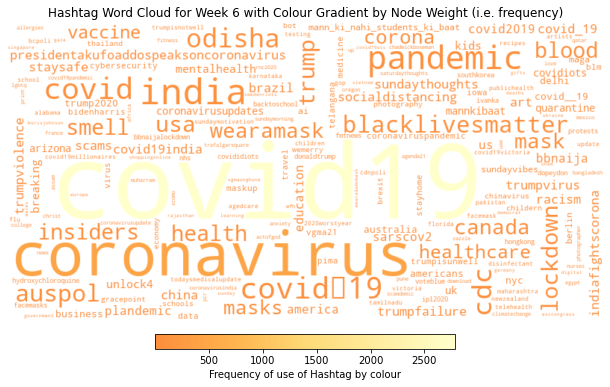

In [27]:
for idx in range(6):
    hashtag_weights, normalized_weights_dict, weights, colour_map = get_graph_weights_colours(f"graphs/week_{idx+1}.gexf", idx)
    create_wordcloud(hashtag_weights, normalized_weights_dict, weights, colour_map, idx)
    

In [24]:
for n, d in G.nodes(data=True):
    print(n,d)

coronavirusupdates {'weight': 78, 'label': 'coronavirusupdates', 'normalized_weight': 0.01294988227379751}
covid19 {'weight': 5947, 'label': 'covid19', 'normalized_weight': 1.0}
coronavirus {'weight': 953, 'label': 'coronavirus', 'normalized_weight': 0.16010763538513287}
recruiting {'weight': 2, 'label': 'recruiting', 'normalized_weight': 0.00016818028927009755}
hurricanehanna {'weight': 10, 'label': 'hurricanehanna', 'normalized_weight': 0.0015136226034308778}
logo {'weight': 1, 'label': 'logo', 'normalized_weight': 0.0}
graphicdesigner {'weight': 1, 'label': 'graphicdesigner', 'normalized_weight': 0.0}
logodesign {'weight': 2, 'label': 'logodesign', 'normalized_weight': 0.00016818028927009755}
logodesinger {'weight': 1, 'label': 'logodesinger', 'normalized_weight': 0.0}
icon {'weight': 1, 'label': 'icon', 'normalized_weight': 0.0}
minimalist {'weight': 1, 'label': 'minimalist', 'normalized_weight': 0.0}
abstract {'weight': 4, 'label': 'abstract', 'normalized_weight': 0.00050454086781

cdb {'weight': 1, 'label': 'cdb', 'normalized_weight': 0.0}
challexfc {'weight': 1, 'label': 'challexfc', 'normalized_weight': 0.0}
posh_e {'weight': 1, 'label': 'posh_e', 'normalized_weight': 0.0}
emmmpozi_water {'weight': 1, 'label': 'emmmpozi_water', 'normalized_weight': 0.0}
merrygoround {'weight': 1, 'label': 'merrygoround', 'normalized_weight': 0.0}
medicalmarijuana {'weight': 2, 'label': 'medicalmarijuana', 'normalized_weight': 0.00016818028927009755}
girls {'weight': 1, 'label': 'girls', 'normalized_weight': 0.0}
rihanna {'weight': 1, 'label': 'rihanna', 'normalized_weight': 0.0}
uspolitics {'weight': 1, 'label': 'uspolitics', 'normalized_weight': 0.0}
coronawatch {'weight': 1, 'label': 'coronawatch', 'normalized_weight': 0.0}
cmsd {'weight': 1, 'label': 'cmsd', 'normalized_weight': 0.0}
fit {'weight': 1, 'label': 'fit', 'normalized_weight': 0.0}
healthy {'weight': 4, 'label': 'healthy', 'normalized_weight': 0.0005045408678102926}
meditation {'weight': 1, 'label': 'meditation',

trash {'weight': 1, 'label': 'trash', 'normalized_weight': 0.0}
theoffice {'weight': 1, 'label': 'theoffice', 'normalized_weight': 0.0}
michaelscott {'weight': 1, 'label': 'michaelscott', 'normalized_weight': 0.0}
thatsehatshesaid {'weight': 1, 'label': 'thatsehatshesaid', 'normalized_weight': 0.0}
maskon {'weight': 4, 'label': 'maskon', 'normalized_weight': 0.0005045408678102926}
islaholbox {'weight': 1, 'label': 'islaholbox', 'normalized_weight': 0.0}
wuhan {'weight': 2, 'label': 'wuhan', 'normalized_weight': 0.00016818028927009755}
nihilism {'weight': 1, 'label': 'nihilism', 'normalized_weight': 0.0}
keepdistance {'weight': 1, 'label': 'keepdistance', 'normalized_weight': 0.0}
hallavstand {'weight': 1, 'label': 'hallavstand', 'normalized_weight': 0.0}
cycling {'weight': 4, 'label': 'cycling', 'normalized_weight': 0.0005045408678102926}
goteborg {'weight': 1, 'label': 'goteborg', 'normalized_weight': 0.0}
constructionworkers {'weight': 1, 'label': 'constructionworkers', 'normalized_w

afghan {'weight': 2, 'label': 'afghan', 'normalized_weight': 0.00016818028927009755}
comedy {'weight': 5, 'label': 'comedy', 'normalized_weight': 0.0006727211570803902}
events {'weight': 2, 'label': 'events', 'normalized_weight': 0.00016818028927009755}
film {'weight': 2, 'label': 'film', 'normalized_weight': 0.00016818028927009755}
funny {'weight': 4, 'label': 'funny', 'normalized_weight': 0.0005045408678102926}
indie {'weight': 1, 'label': 'indie', 'normalized_weight': 0.0}
twitterfilm {'weight': 1, 'label': 'twitterfilm', 'normalized_weight': 0.0}
bharathikannamma {'weight': 1, 'label': 'bharathikannamma', 'normalized_weight': 0.0}
rettairoja {'weight': 1, 'label': 'rettairoja', 'normalized_weight': 0.0}
mohap_uae {'weight': 1, 'label': 'mohap_uae', 'normalized_weight': 0.0}
rebirthoftheun {'weight': 1, 'label': 'rebirthoftheun', 'normalized_weight': 0.0}
dominicummimgs {'weight': 4, 'label': 'dominicummimgs', 'normalized_weight': 0.0005045408678102926}
achieving {'weight': 1, 'labe

cashutdown {'weight': 1, 'label': 'cashutdown', 'normalized_weight': 0.0}
arianagrande {'weight': 1, 'label': 'arianagrande', 'normalized_weight': 0.0}
arianator {'weight': 1, 'label': 'arianator', 'normalized_weight': 0.0}
ari {'weight': 1, 'label': 'ari', 'normalized_weight': 0.0}
happiana {'weight': 1, 'label': 'happiana', 'normalized_weight': 0.0}
thankyounext {'weight': 1, 'label': 'thankyounext', 'normalized_weight': 0.0}
sweetener {'weight': 1, 'label': 'sweetener', 'normalized_weight': 0.0}
dangerouswoman {'weight': 1, 'label': 'dangerouswoman', 'normalized_weight': 0.0}
myeverything {'weight': 1, 'label': 'myeverything', 'normalized_weight': 0.0}
dharavi {'weight': 2, 'label': 'dharavi', 'normalized_weight': 0.00016818028927009755}
recoveryrate {'weight': 1, 'label': 'recoveryrate', 'normalized_weight': 0.0}
numbers {'weight': 1, 'label': 'numbers', 'normalized_weight': 0.0}
cases {'weight': 3, 'label': 'cases', 'normalized_weight': 0.0003363605785401951}
confirmed {'weight': 

jax {'weight': 1, 'label': 'jax', 'normalized_weight': 0.0}
covidcoping {'weight': 1, 'label': 'covidcoping', 'normalized_weight': 0.0}
biotechindustry {'weight': 1, 'label': 'biotechindustry', 'normalized_weight': 0.0}
nstleader {'weight': 1, 'label': 'nstleader', 'normalized_weight': 0.0}
ibd {'weight': 1, 'label': 'ibd', 'normalized_weight': 0.0}
leronlimab {'weight': 2, 'label': 'leronlimab', 'normalized_weight': 0.00016818028927009755}
blog {'weight': 3, 'label': 'blog', 'normalized_weight': 0.0003363605785401951}
teletherapy {'weight': 1, 'label': 'teletherapy', 'normalized_weight': 0.0}
coping {'weight': 1, 'label': 'coping', 'normalized_weight': 0.0}
lotr {'weight': 1, 'label': 'lotr', 'normalized_weight': 0.0}
tolkien {'weight': 1, 'label': 'tolkien', 'normalized_weight': 0.0}
aging {'weight': 1, 'label': 'aging', 'normalized_weight': 0.0}
jk {'weight': 1, 'label': 'jk', 'normalized_weight': 0.0}
reports {'weight': 2, 'label': 'reports', 'normalized_weight': 0.0001681802892700

eyeroll {'weight': 1, 'label': 'eyeroll', 'normalized_weight': 0.0}
sass {'weight': 1, 'label': 'sass', 'normalized_weight': 0.0}
sarcasm {'weight': 1, 'label': 'sarcasm', 'normalized_weight': 0.0}
american {'weight': 5, 'label': 'american', 'normalized_weight': 0.0006727211570803902}
tragedy {'weight': 1, 'label': 'tragedy', 'normalized_weight': 0.0}
breathingvalves {'weight': 1, 'label': 'breathingvalves', 'normalized_weight': 0.0}
hajj2020 {'weight': 1, 'label': 'hajj2020', 'normalized_weight': 0.0}
gr8est {'weight': 1, 'label': 'gr8est', 'normalized_weight': 0.0}
knownfor {'weight': 1, 'label': 'knownfor', 'normalized_weight': 0.0}
fridaymood {'weight': 1, 'label': 'fridaymood', 'normalized_weight': 0.0}
eatingdisorder {'weight': 1, 'label': 'eatingdisorder', 'normalized_weight': 0.0}
cod {'weight': 1, 'label': 'cod', 'normalized_weight': 0.0}
wow {'weight': 1, 'label': 'wow', 'normalized_weight': 0.0}
yeet {'weight': 1, 'label': 'yeet', 'normalized_weight': 0.0}
codtopplays {'weig

just_saying {'weight': 1, 'label': 'just_saying', 'normalized_weight': 0.0}
markets {'weight': 1, 'label': 'markets', 'normalized_weight': 0.0}
mankibaat {'weight': 1, 'label': 'mankibaat', 'normalized_weight': 0.0}
pm {'weight': 1, 'label': 'pm', 'normalized_weight': 0.0}
kargilwar {'weight': 1, 'label': 'kargilwar', 'normalized_weight': 0.0}
selfiesunday {'weight': 1, 'label': 'selfiesunday', 'normalized_weight': 0.0}
godees {'weight': 1, 'label': 'godees', 'normalized_weight': 0.0}
defence {'weight': 1, 'label': 'defence', 'normalized_weight': 0.0}
goodidea {'weight': 1, 'label': 'goodidea', 'normalized_weight': 0.0}
maryland {'weight': 1, 'label': 'maryland', 'normalized_weight': 0.0}
amitabhbachchancovidpositive {'weight': 1, 'label': 'amitabhbachchancovidpositive', 'normalized_weight': 0.0}
educational {'weight': 1, 'label': 'educational', 'normalized_weight': 0.0}
twentytwenty {'weight': 1, 'label': 'twentytwenty', 'normalized_weight': 0.0}
laprotests {'weight': 1, 'label': 'lap

glaciernationalpark {'weight': 1, 'label': 'glaciernationalpark', 'normalized_weight': 0.0}
findyourpark {'weight': 1, 'label': 'findyourpark', 'normalized_weight': 0.0}
gosomewhere {'weight': 1, 'label': 'gosomewhere', 'normalized_weight': 0.0}
ffswearamask {'weight': 1, 'label': 'ffswearamask', 'normalized_weight': 0.0}
worldeconomicforum {'weight': 1, 'label': 'worldeconomicforum', 'normalized_weight': 0.0}
cyclingforlife {'weight': 1, 'label': 'cyclingforlife', 'normalized_weight': 0.0}
walking {'weight': 1, 'label': 'walking', 'normalized_weight': 0.0}
nia {'weight': 1, 'label': 'nia', 'normalized_weight': 0.0}
uapa {'weight': 1, 'label': 'uapa', 'normalized_weight': 0.0}
regisphilbin {'weight': 3, 'label': 'regisphilbin', 'normalized_weight': 0.0003363605785401951}
itsokaynottobeokayep11 {'weight': 1, 'label': 'itsokaynottobeokayep11', 'normalized_weight': 0.0}
oneloveoneheart {'weight': 1, 'label': 'oneloveoneheart', 'normalized_weight': 0.0}
gurumountkailash {'weight': 1, 'labe